In [12]:
import torch
import torch.nn as nn


import torch.optim as optim

import torchvision

import matplotlib.pyplot as plt

#import model
#import utils

import argparse
import torchvision.transforms as transforms

from PIL import Image
import torch.nn.functional as F

import torchvision.models as models

## import target images(content image and style image)
def loader(content_img, style_img, size):
    content_img = Image.open(content_img)
    style_img = Image.open(style_img)
    content_img = convert_mode(content_img)
    style_img = convert_mode(style_img)
    transform = transforms.Compose([    # convert img into the data format
        transforms.Resize((size,size)),  # scale imported image
        transforms.ToTensor()  # the order is important 'Resize first and ToTensor'
    ])
    content_img_rsz = transform(content_img)
    style_img_rsz = transform(style_img)

    imshow(content_img_rsz, title = 'Content Image')
    imshow(style_img_rsz, title = 'Style Image')

    content_img = content_img_rsz.unsqueeze(0)
    style_img = style_img_rsz.unsqueeze(0)

    return content_img, style_img


## visualize resized target images
def imshow(image, title = None):
    image = image.clone()
    image = image.squeeze(0)
    pil = transforms.ToPILImage()
    target_img_PIL = pil(image)
    plt.figure()
    plt.imshow(target_img_PIL)
    if title is not None:
        plt.title(title)
    plt.pause(1)


## gram_matrix for the 'style loss function'
def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(-1, h*w)
    G = torch.mm(features, features.t())
    return G.div(b*c*h*w)


class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

## RGBA 2 RGB
def convert_mode(img):
    if img.mode == "RGB":
        return img
    elif img.mode == "RGBA":
        background = Image.new("RGB", img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])
        background.save(img.filename, quality=100)
        converted_img = Image.open(img.filename)
        return converted_img

## check if images are successfully loaded
# loader("images/arizona.jpg", "images/snow.jpg", 128)

In [13]:
'''
VGG19
(0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(1): ReLU(inplace)
(2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(3): ReLU(inplace)
(4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(6): ReLU(inplace)
(7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(8): ReLU(inplace)
(9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(11): ReLU(inplace)
(12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(13): ReLU(inplace)
(14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(15): ReLU(inplace)
(16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(17): ReLU(inplace)
(18): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(19): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(20): ReLU(inplace)
(21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(22): ReLU(inplace)
(23): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(24): ReLU(inplace)
(25): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(26): ReLU(inplace)
(27): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(29): ReLU(inplace)
(30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(31): ReLU(inplace)
(32): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(33): ReLU(inplace)
(34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(35): ReLU(inplace)
(36): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
'''

###############################################################
# The Neural Style Transfer includes only 10 layers of VGG19. #
# Conv: ['0','2','5','7', '10']                               #
# ReLU: ['1','3','6','8']                                     #
# Maxpool: ['4','9']                                          #
###############################################################





gram_matrix = gram_matrix
Normalization = Normalization

## 'content loss function' and 'style loss function'
class CL(nn.Module):
    def __init__(self, target):
        super(CL, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class SL(nn.Module):
    def __init__(self, target):
        super(SL, self).__init__()
        self.target = gram_matrix(target).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Generating the 'Neural Style Transfer' Model
def nst_model(content_img, style_img):
    vgg = models.vgg19(pretrained=True).features.eval()
    normalization = Normalization(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

    content_img = content_img.detach()
    style_img = style_img.detach()
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    i = 0
    for name, layer in vgg._modules.items():
        if name in ['0','2','5','10']:
            model.add_module('conv_{}'.format(i),layer)
            style_target = model(style_img)
            style_loss = SL(style_target)
            style_losses.append(style_loss)
            model.add_module('styleloss_{}'.format(i),style_loss)
            i += 1

        elif name in ['7']:
            model.add_module('conv_{}'.format(i),layer)
            content_target = model(content_img)
            content_loss = CL(content_target)
            content_losses.append(content_loss)
            model.add_module('contentloss_{}'.format(i),content_loss)
            style_target = model(style_img)
            style_loss = SL(style_target)
            style_losses.append(style_loss)
            model.add_module('styleloss_{}'.format(i),style_loss)
            i += 1

        elif name in ['1','3','6','8']:
            layer = nn.ReLU(inplace=False)
            model.add_module('relu_{}'.format(i),layer)
            i += 1

        elif name in ['4','9']:
            model.add_module('maxpool_{}'.format(i),layer)
            i += 1

        elif name == '11':
            break

    return model, style_losses, content_losses

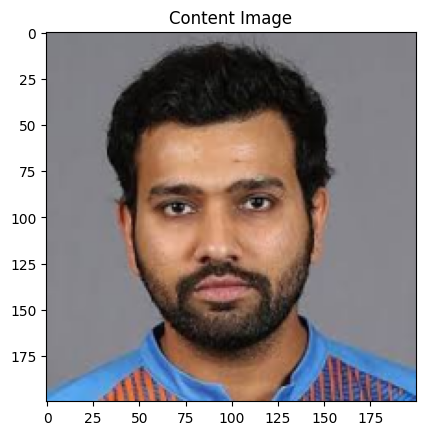

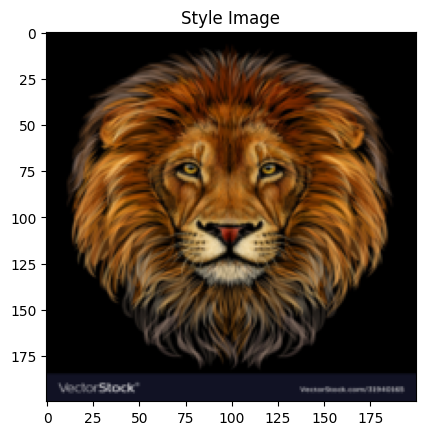

Step : [0]
Style Loss : 830.173584 Content Loss: 0.000000 TV Loss: 5174.211914
Step : [50]
Style Loss : 87.332108 Content Loss: 8.785501 TV Loss: 7564.462402
Step : [100]
Style Loss : 50.956089 Content Loss: 11.235245 TV Loss: 7487.534180
Step : [150]
Style Loss : 40.582859 Content Loss: 11.832468 TV Loss: 7206.346191
Step : [200]
Style Loss : 35.385384 Content Loss: 12.329374 TV Loss: 6970.538086
Step : [250]
Style Loss : 31.951210 Content Loss: 12.682490 TV Loss: 6782.859375
Step : [300]
Style Loss : 30.077072 Content Loss: 12.891357 TV Loss: 6587.793457
Step : [350]
Style Loss : 28.719767 Content Loss: 13.117763 TV Loss: 6476.290039
Step : [400]
Style Loss : 28.100956 Content Loss: 13.438391 TV Loss: 6443.793457


<Figure size 640x480 with 0 Axes>

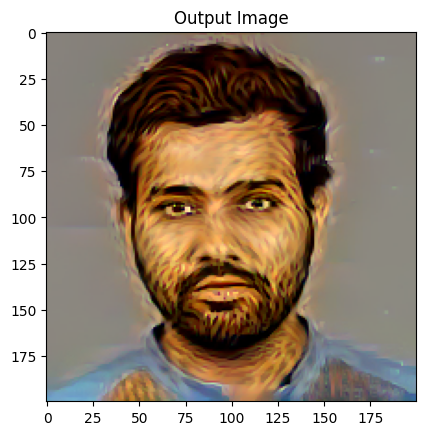

In [18]:

def main(content_img_path, style_img_path, size=256, steps=500, c_weight=1, s_weight=100000):
    content_img, style_img = loader(content_img_path, style_img_path, size=size)
    input_img = content_img.clone()

    model, style_losses, content_losses = nst_model(content_img, style_img)

    optimizer = optim.LBFGS([input_img.requires_grad_()], lr=0.1)  # Adjust the learning rate

    step = [0]
    while step[0] <= steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            output = model(input_img)

            cl = 0
            sl = 0

            for c_loss in content_losses:
                cl += c_loss.loss * c_weight
            for s_loss in style_losses:
                sl += s_loss.loss * s_weight

            # Add total variation regularization
            tv_loss = torch.sum(torch.abs(input_img[:, :, :, :-1] - input_img[:, :, :, 1:])) + \
                      torch.sum(torch.abs(input_img[:, :, :-1, :] - input_img[:, :, 1:, :]))
            total_loss = cl + sl + 0.01 * tv_loss  # Adjust the regularization weight (0.01 in this example)

            total_loss.backward()

            if step[0] % 50 == 0:
                print('Step : {}'.format(step))
                print('Style Loss : {:3f} Content Loss: {:3f} TV Loss: {:3f}'.format(
                    sl.item(), cl.item(), tv_loss.item()))

            step[0] += 1

            return total_loss

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

# Example usage
content_image_path = 'rohit.jpg'
style_image_path = 'lion1.jpg'
output_image = main(content_image_path, style_image_path, size=200, steps=400, c_weight=1, s_weight=100000)

plt.figure()
imshow(output_image, title='Output Image')
plt.show()




** Here are few output images **







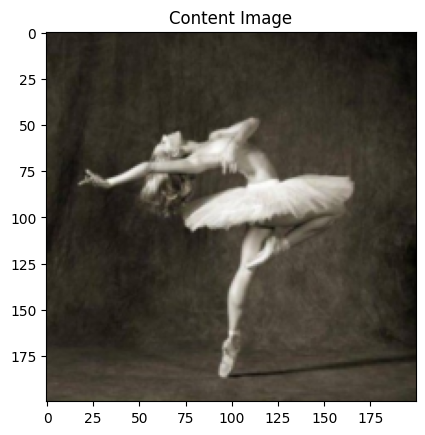

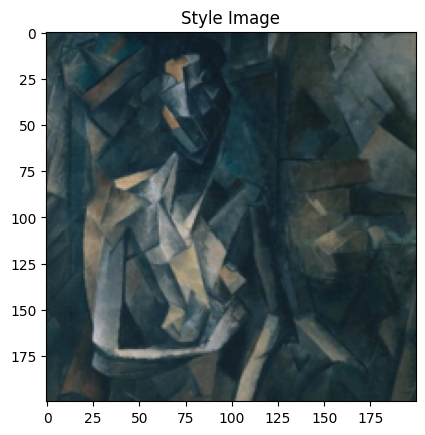

Step : [0]
Style Loss : 174.434601 Content Loss: 0.000000 TV Loss: 4076.153320
Step : [50]
Style Loss : 26.988518 Content Loss: 4.302885 TV Loss: 3887.045410
Step : [100]
Style Loss : 16.017353 Content Loss: 4.918106 TV Loss: 3595.278809
Step : [150]
Style Loss : 9.108525 Content Loss: 5.306298 TV Loss: 3403.769287
Step : [200]
Style Loss : 5.604874 Content Loss: 5.419333 TV Loss: 3229.188965
Step : [250]
Style Loss : 4.312925 Content Loss: 5.392051 TV Loss: 3098.546631
Step : [300]
Style Loss : 3.957669 Content Loss: 5.324982 TV Loss: 3014.231934
Step : [350]
Style Loss : 3.874166 Content Loss: 5.277255 TV Loss: 2959.633301
Step : [400]
Style Loss : 3.842769 Content Loss: 5.242706 TV Loss: 2923.155273


<Figure size 640x480 with 0 Axes>

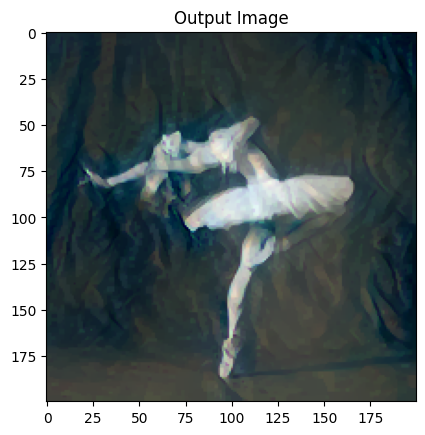

In [22]:
# Example usage
content_image_path = 'dancing.jpg'
style_image_path = 'picasso.jpg'
output_image = main(content_image_path, style_image_path, size=200, steps=400, c_weight=1, s_weight=100000)

plt.figure()
imshow(output_image, title='Output Image')
plt.show()


<h1>Optimizers:</h1>
<h3>L-BFGS (Limited-memory Broyden–Fletcher–Goldfarb–Shanno):</h3>
Significance:
L-BFGS is a popular optimization algorithm for unconstrained optimization problems.
It's well-suited for optimization problems with a large number of variables, making it useful for neural style transfer where the generated image is represented by pixel values.
L-BFGS approximates the inverse Hessian matrix, making it memory-efficient.
Usage in Neural Style Transfer:
L-BFGS is often used in neural style transfer due to its stability and efficiency in optimizing the pixel values of the generated image.
It's particularly suitable for problems where the objective function is computationally expensive to evaluate, as is the case in neural style transfer.

<h3>Adam (Adaptive Moment Estimation):</h3>
Significance:

Adam is a popular optimization algorithm for deep learning tasks.
It adapts the learning rates for each parameter individually, allowing for faster convergence.
It combines ideas from momentum and RMSprop to achieve efficient optimization.
Usage in Neural Style Transfer:

Adam is a good alternative for neural style transfer, especially in scenarios where memory efficiency is not as critical.
It might converge faster than L-BFGS but could require tuning of hyperparameters such as learning rates.
Loss Functions:
<h3>Mean Squared Error (MSE) Loss:</h3>
Significance:

MSE loss measures the average squared difference between predicted and target values.
It is commonly used for regression tasks, but in neural style transfer, it's adapted for comparing feature representations.
Usage in Neural Style Transfer:

<h3>Content Loss:</h3> MSE loss is often used to measure the difference in feature representations between the generated image and the content image.

<h3>Style Loss:</h3> MSE loss is applied to the Gram matrices of feature maps to capture the style information.
<h3>Total Variation (TV) Loss:</h3>
Significance:

TV loss measures the total variation in pixel values, penalizing spatial variations.
It helps to reduce noise and produce smoother images.
Usage in Neural Style Transfer:

TV loss is added to the total loss to encourage spatial smoothness in the generated image.
It helps prevent overly detailed and noisy artifacts in the stylized image.


<h2>Model Architecture:</h2>
<h3>VGG (Visual Geometry Group) Network:</h3>
Significance:

VGG is a deep convolutional neural network architecture.
It has a simple and uniform architecture, making it easy to understand and implement.
Pre-trained VGG models are often used in transfer learning tasks due to their effectiveness in feature extraction.
Usage in Neural Style Transfer:

VGG is used as a feature extractor in neural style transfer.
The intermediate feature maps of the VGG network are used to compute content and style losses.
In summary, the choice of optimizer, loss functions, and model architecture in your code reflects a common setup for neural style transfer. L-BFGS is chosen for stability and efficiency, MSE loss is used for content and style comparisons, and the VGG network is employed as a feature extractor. The TV loss is added to encourage smoothness in the generated image. These choices strike a balance between computational efficiency and the ability to capture content and style information effectively.







# Limitations of Neural Style Transfer:

1. **Lack of Semantic Control:**
   - Neural style transfer typically operates at the level of low to mid-level features and lacks semantic understanding. This can result in the style being applied indiscriminately across different semantic regions of the content image.

2. **Style Transfer Inconsistency:**
   - The degree of stylization can vary based on the content image and the chosen style. Some styles may transfer more effectively than others, and achieving consistency across different styles can be challenging.

3. **Dependency on Pre-trained Models:**
   - The quality of stylized images is highly dependent on the choice of pre-trained models for feature extraction. Using models trained on specific datasets may limit the ability to generalize to diverse styles.

4. **Limited Real-Time Processing:**
   - Real-time style transfer for high-resolution images is often impractical due to the computational intensity of the process, making it challenging for applications that require low-latency processing.

5. **Difficulty in Preserving Content Details:**
   - Balancing style transfer while preserving important content details can be challenging. Stylized images may sometimes lose fine details, resulting in a loss of information.

6. **Artifacts and Over-smoothing:**
   - The generated images may contain artifacts or exhibit over-smoothing, especially when regularization techniques are applied. Achieving a balance between stylization and maintaining image details is a delicate task.

# Potential Improvements and Advances:

1. **Semantic-aware Style Transfer:**
   - Developing methods that incorporate semantic information to guide style transfer could lead to more contextually relevant results. Techniques that consider object boundaries and semantics may improve the overall quality of stylized images.

2. **Multi-Style Transfer:**
   - Enhancing algorithms to handle multiple styles within a single image or allowing users to control style transfer at a finer level of detail can increase flexibility and creative possibilities.

3. **Adaptive Style Transfer:**
   - Exploring adaptive style transfer models that adjust the degree of stylization based on image content, scene complexity, or user preferences can lead to more versatile and customizable results.

4. **Improved Regularization Techniques:**
   - Developing advanced regularization techniques to reduce artifacts and improve spatial coherence without sacrificing stylization quality. This could involve more sophisticated methods for total variation regularization or novel approaches.

5. **Real-time Processing Optimization:**
   - Research and development of optimized algorithms that enable real-time or near-real-time style transfer, potentially leveraging hardware acceleration or more efficient neural network architectures.

6. **User Interaction and Control:**
   - Incorporating interactive features that allow users to guide the style transfer process in real-time, providing a more intuitive and creative experience.

7. **Unsupervised Style Transfer:**
   - Exploring unsupervised or self-supervised approaches that do not rely on predefined style images, allowing the model to learn style representations directly from the content.

8. **Domain-specific Style Transfer:**
   - Tailoring style transfer models for specific domains, such as art, fashion, or architecture, to ensure that the transfer aligns with domain-specific aesthetics.

9. **Evaluation Metrics:**
   - Developing standardized evaluation metrics to assess the quality and perceptual consistency of stylized images. This can help researchers and practitioners compare different style transfer methods more objectively.
